In [51]:
import numpy as np
import cv2
import pandas as pd
import os
import importlib
import time
import matplotlib.pyplot as plt
import os
from skimage.exposure import rescale_intensity
import copy
import math

In [52]:
class point2d():
    def __init__(self, value, x=-1, y=-1, coord=None):
        if coord is not None:
            self.x = coord[0]
            self.y = coord[1]
        else:
            self.x = x 
            self.y = y
            
        self.value = value

In [53]:
class descriptor():
    def __init__(self, point, ori, desc):
        self.orientation = ori
        self.point = point
        self.desc = desc
    def setdesc(self, desc):
        self.desc = desc

In [54]:
SRCIMG = "./images/wall.jpeg"

In [55]:
def compute_harris_responce(im, sigma=1.5):
    """
        Compute the Harris response of each pixel
        in the gray-scale image.
    """
    from scipy.ndimage import filters
    import numpy as np

    Ix = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), Ix)
    #Ix = cv2.Sobel(im, -1, 1, 0, ksize=3)
    Iy = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), Iy)
    #Iy = cv2.Sobel(im, -1, 0, 1, ksize=3)
    
    # compute Harris corner
    Wxx = filters.gaussian_filter(Ix**2, sigma)
    Wxy = filters.gaussian_filter(Ix*Iy, sigma)
    Wyy = filters.gaussian_filter(Iy**2, sigma)

    Wdet = Wxx * Wyy - Wxy ** 2
    Wtr = Wxx + Wyy
    return Wdet/Wtr  
    


In [56]:
#if __name__ == "__main__":
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy.ndimage import filters



## Compute Harris Coner Response

In [57]:
def upscaling(src, idx):
    if idx <= 0:
        return src 
    src = upscaling(cv2.pyrUp(cv2.pyrUp(src)), idx-1)
    return src

In [69]:
#pli_img = Image.open(SRCIMG).convert("L")
#orimg = np.array(Image.open(SRCIMG))
#img = np.array(pli_img)
orimg = cv2.imread(SRCIMG)
img = cv2.cvtColor(orimg,cv2.COLOR_BGR2GRAY)

hrpy = [] #harris response pyramid
srcs = [] #image source pyramid
src = img
for i in range(2):
    dst = compute_harris_responce(src)
    #srcs.append(cv2.resize(upscaling(src, i), (img.shape[1], img.shape[0]))) # store the origin size src
    #hrpy.append(cv2.resize(upscaling(dst, i), (img.shape[1], img.shape[0]))) # store the origin size response
    srcs.append(src) # store the origin size src
    hrpy.append(dst) # store the origin size response
    src = cv2.pyrDown(cv2.pyrDown(src))



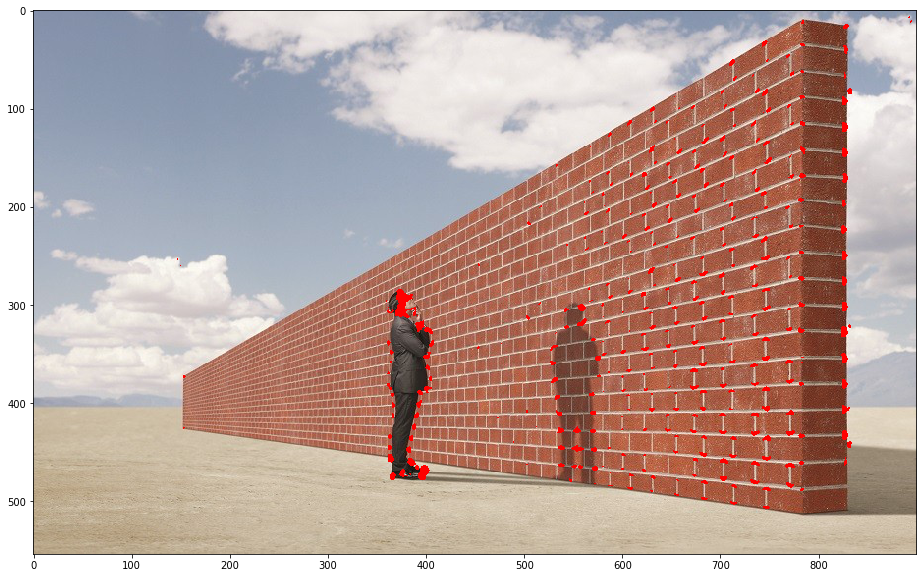

In [70]:
pltimg = copy.deepcopy(orimg)
plt.figure(figsize=(20, 10))
dst = hrpy[0]
pltimg[dst>(0.1*dst.max())]=[0, 0, 255]
plt.imshow(cv2.cvtColor(pltimg, cv2.COLOR_BGR2RGB)) 

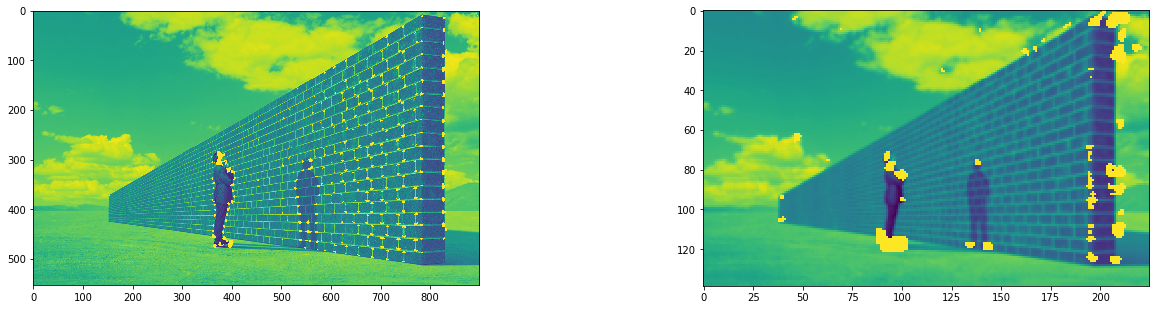

In [76]:
fig=plt.figure(figsize=(20, 10))
columns = len(hrpy)
rows = 1
for i in range(1, columns*rows+1):
    dst = hrpy[i-1]
    src = srcs[i-1]
    srcimg = copy.deepcopy(src)
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    srcimg[dst>(0.1*dst.max())]=[255]
    plt.imshow(srcimg) 
    
plt.show()

## Save to Feature Points

In [11]:
"""
fps = [] #feature points 
for hr in hrpy:
    #fps = []
    for i in range(hr.shape[0]):
        for j in range(hr.shape[1]):
            v = hr[i, j]
            if v > hr.max()*0.1:
                fps.append(point2d(i, j, v))
"""

'\nfps = [] #feature points \nfor hr in hrpy:\n    #fps = []\n    for i in range(hr.shape[0]):\n        for j in range(hr.shape[1]):\n            v = hr[i, j]\n            if v > hr.max()*0.1:\n                fps.append(point2d(i, j, v))\n'

## Non Maximum Suppression

In [72]:
def masksurby(src, ind, r, num):
    # for grayscale
    L0 = (ind[0] - r) if ((ind[0] - r) >= 0) else 0
    L1 = (ind[1] - r) if ((ind[1] - r) >= 0) else 0
    U0 = (ind[0] + r) if ((ind[0] + r) <= src.shape[0]) else src.shape[0]
    U1 = (ind[1] + r) if ((ind[1] + r) <= src.shape[1]) else src.shape[1]
    src[L0:U0, L1:U1] = num
    return src
def maskonly(src, ind, diameter):
    r = diameter//2
    masked = np.zeros((r, r))
    max0, max1= src.shape
    # for grayscale
    L0 = (ind[0] - r) if ((ind[0] - r) >= 0) else 0
    L1 = (ind[1] - r) if ((ind[1] - r) >= 0) else 0
    U0 = (ind[0] + r) if ((ind[0] + r) <= max0) else max0
    U1 = (ind[1] + r) if ((ind[1] + r) <= max1) else max1
    """
    print(src.shape)
    print(ind)
    print('L1:', L1)
    print('U1:', U1)
    print('L0:', L0)
    print('U0:', U0)
    """
    masked = src[L0:U0, L1:U1]
    #print('masked.shape:', masked.shape)
    return masked

In [18]:
src.shape

(554, 900)

In [73]:
# while (not enough feature point selected)
# set r - 1
# while (features is not all zeros)
#   sort features
#   find max(selected), and replace its surrounded and itself by zeros

def nonmaxsup(src, maxf=500, r=51):
    fps = []
    while(len(fps) <= maxf):
        r = r - 1
        fmap = copy.deepcopy(src)
        
        # mask sur
        for p in fps:
            fmap =  masksurby(fmap, (p.x, p.y), r, 0)
        maxn = 1e8
        while(maxn > src.max()*0.05):
            ind = np.unravel_index(np.argmax(fmap, axis=None), fmap.shape)
            maxn = fmap[ind]
            fmap = masksurby(fmap, ind, r, 0)
            
            fps.append(point2d(value = maxn, coord = ind)) # collect new selected feature
    return fps

In [74]:
fpspy = []
for hr in hrpy:
    fpspy.append(nonmaxsup(hr, maxf=150))

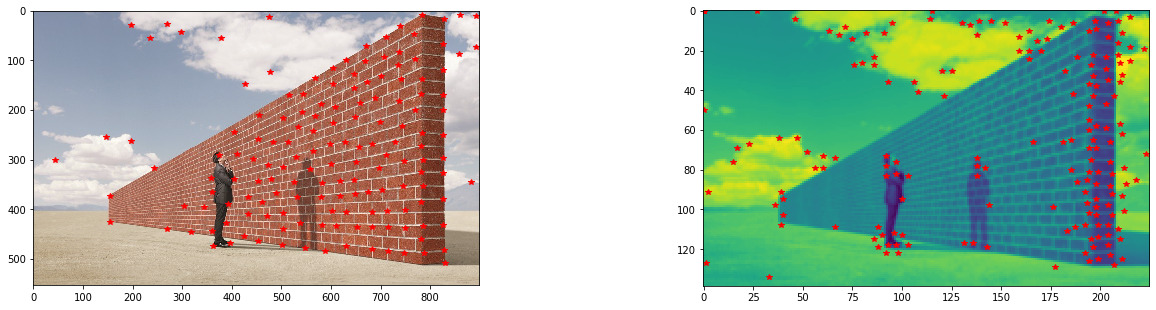

In [78]:
from matplotlib.patches import Rectangle

fig=plt.figure(figsize=(20, 10))
columns = len(hrpy)
rows = 1
for i in range(1, columns*rows+1):
    pltimg = orimg
    src = srcs[i-1]
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    if(i==1):
        plt.imshow(cv2.cvtColor(pltimg, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(src)
    for p in fpspy[i-1]:
        plt.plot( p.y, p.x, 'r*')
    
plt.show()

## Descriptor (Orientation included)

In [79]:
# take too long?

In [80]:
descspy = []
for i in range(len(fpspy)):
    fps = fpspy[i]
    src = srcs[i]
    gx = cv2.Sobel(src, cv2.CV_32F, 1, 0, ksize=5)
    gy = cv2.Sobel(src, cv2.CV_32F, 0, 1, ksize=5)
    descs = []
    #print('-'*80)
    for fp in fps:
        #print('1')
        ind = (fp.x, fp.y)
        rmat = cv2.getRotationMatrix2D(ind, math.atan2(gx[ind], gy[ind]), scale=1.0)
        #print('2')
        rimg = cv2.warpAffine(src, rmat, (src.shape[1], src.shape[0]))
        #print('3')
        masked = maskonly(rimg, ind, 40)
        #print('4')
        #print(masked.shape)
        #print(masked)
        if (masked.shape[1]==0):
            print('!:', ind)
            break
        blurf = cv2.GaussianBlur(masked, ksize=(5, 5), sigmaX=1, sigmaY=1)
        #print(blurf.shape)
        #print(blurf)
        #print('4.3')
        resizef = cv2.resize(blurf, (8, 8)) # 8*8
        #print('4.5')
        normf = (resizef-np.mean(resizef))/np.std(resizef) 
        #print('5')
        descs.append(descriptor(fp, (gx[ind], gy[ind]), normf))
        #print('6')
    descspy.append(descs)

/home/tsai/anaconda3/envs/torch-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


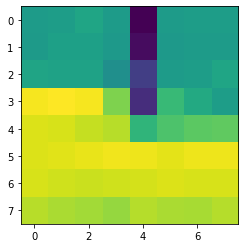

In [81]:
plt.imshow(descs[0].desc)

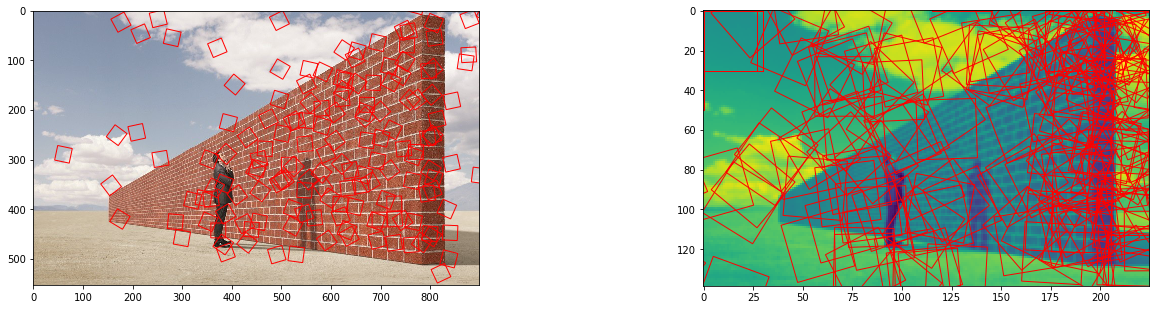

In [85]:
from matplotlib.patches import Rectangle

fig=plt.figure(figsize=(20, 10))
columns = len(hrpy)
rows = 1
for i in range(1, columns*rows+1):
    pltimg = orimg
    src = srcs[i-1]
    fig.subplots_adjust(wspace=0.5)
    fig.add_subplot(rows, columns, i)
    if(i==1):
        plt.imshow(cv2.cvtColor(pltimg, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(src)
    ax = plt.gca()
    for d in descspy[i-1]:
        rect = Rectangle( (d.point.y, d.point.x), 30, 30, angle=math.degrees(math.atan2(d.orientation[0], d.orientation[1])), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
plt.show()